### Gabriel Marcelino
### January 15, 2025
### Performance Predictions
#### Stock: NVIDIA (NVDA)

1. Import Required Libraries

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

2. Data set-up and exploration

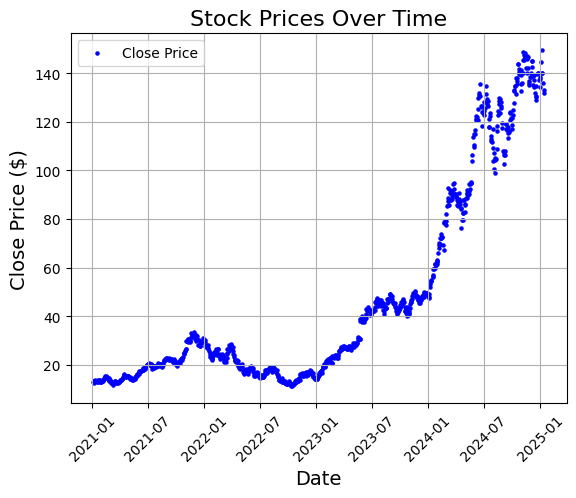

In [8]:
# Load the CSV file
data = pd.read_csv('stock-data.csv')

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date to datetime
data['Close/Last'] = data['Close/Last'].replace({'\$': ''}, regex=True).astype(float)  # Remove $ and convert to float

# Extract X and Y
# X will be days after the first date in the dataset since model can't handle date format
reference_date = data['Date'].min()

# Calculate days since the reference date
data['Days'] = (data['Date'] - reference_date).dt.days

# Extract X and Y
X = data['Days']  # Days as numeric values
y= data['Close/Last']

# Plot the data using scatter plot
plt.scatter(data['Date'], y, label='Close Price', color='blue', marker='o', s=5)  

# Add labels and title
plt.title('Stock Prices Over Time', fontsize=16)  # Set title
plt.xlabel('Date', fontsize=14)  # Label for X-axis
plt.ylabel('Close Price ($)', fontsize=14)  # Label for Y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for better visualization
plt.legend()  # Add legend for clarity
plt.show()  # Display the scatter plot


3. Prepare training and testing sets, and train model

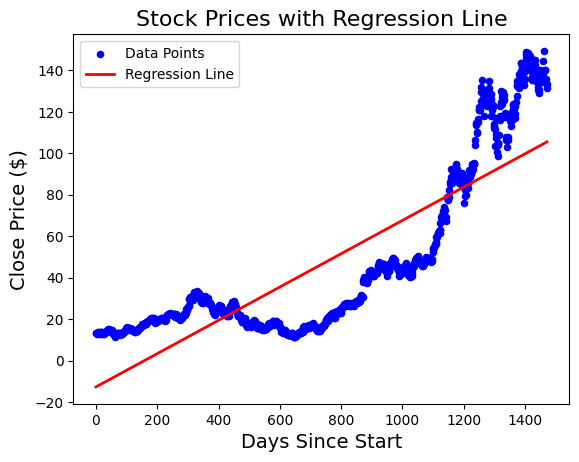

In [12]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Reshape X_train and X_test to be 2-dimensional
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train, y_train)

# Plot the data points
plt.scatter(X, y, label='Data Points', color='blue', marker='o', s=20)  # Smaller dots for data points

# Generate predictions for the regression line
X_sorted = X.sort_values().values.reshape(-1, 1)
y_pred = model.predict(X_sorted)  # Predict using the trained model

# Plot the regression line
plt.plot(X_sorted, y_pred, label='Regression Line', color='red', linewidth=2)  # Red line for regression

# Add labels, title, and legend
plt.title('Stock Prices with Regression Line', fontsize=16)  # Title
plt.xlabel('Days Since Start', fontsize=14)  # X-axis label
plt.ylabel('Close Price ($)', fontsize=14)  # Y-axis label
plt.legend()  # Show legend

plt.show()


4. Test Model

In [4]:
y_pred = model.predict(X_test)

print("Testing Performance:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")




Testing Performance:


NameError: name 'mean_squared_error' is not defined

## Instructions
Linear Models are a useful measure for technical and quantitative analysis in financial markets.

Select a publicly traded stock. Download the historical data about the stock performance from the Yahoo Finance website, located in the topic Resources.

Given its set of performance characteristics and investment objectives, predict its performance using a linear model.

Then, write a comprehensive technical report as a markdown document, including all code, code comments, all outputs, plots, and analysis, addressing the following. Make sure the project documentation contains a) Problem statement, b) Algorithm of the solution, c) Analysis of the findings and d) References.

Data set-up and exploration
Preparing training and testing sets
Build the multiple linear regression model
Improve the model using only significant variables
Regression output interpretation
Calculate residuals
Make predictions using the test set
Model verification
Final investment worthiness predication results


Statistical analysis provides the pure financial considerations for pursuing a course of action, in this case the choice of investing in a company's stock. From a Christian worldview perspective, describe what other factors you would include in an investment decision process, in addition to statistical and financial ones. Would you include these factors in a quantitative manner as part of a computational model, or would you perform a qualitative assessment of the company separate from the statistical assessment? Justify your answer. To what extent is this decision guided by a Christian worldview?